In [ ]:
# Create the data directory if it doesn't already exist
!mkdir -p Data

# Download the file using wget and save it in the data directory
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat -O Data/burgers_shock.mat

!mkdir PINNs
!cd PINNs
!git init
!git remote add origin https://github.com/maziarraissi/PINNs.git
!git config core.sparseCheckout true
!echo "Utilities/IRK_weights/" >> .git/info/sparse-checkout
!git pull origin master
!git sparse-checkout reapply

--2024-04-15 11:04:42--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2024-04-15 11:04:42--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘Data/burgers_shock.mat’

Data/burgers_shock. 100%[===================>] 203.07K  --.-KB/s    in 0.03s   

2024-04-15 11:04:42 (7.71 MB/s) - ‘Data/burgers_shock.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
from torch.optim import LBFGS
import scipy.io
import matplotlib.gridspec as gridspec
torch.manual_seed(1234)

In [ ]:
class PhysicsInformedNN(nn.Module):
    def __init__(self, x0, u0, x1, u1, layers, dt, lb, ub, q):
        super(PhysicsInformedNN, self).__init__()
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)
        self.layers = nn.ModuleList()
        self.dt = dt
        self.q = max(q, 1)

        # Define network layers
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        # Parameters lambda
        self.lambda_1 = nn.Parameter(torch.tensor([0.0]))
        self.lambda_2 = nn.Parameter(torch.tensor([-6.0]))

        # Load IRK weights (needs adaptation if these are to be used)
        self.irk_weights = self.load_irk_weights(q)

        # Placeholder variables
        self.x0 = torch.tensor(x0, requires_grad=True)
        self.u0 = torch.tensor(u0)
        self.x1 = torch.tensor(x1, requires_grad=True)
        self.u1 = torch.tensor(u1)

    def load_irk_weights(self, q):
        # Path to the IRK weights file
        weights_path = f'Utilities/IRK_weights/Butcher_IRK{q}.txt'
        # Load the weights using NumPy
        tmp = np.loadtxt(weights_path, ndmin=2).astype(np.float32)
        weights = np.reshape(tmp[0:q**2+q], (q+1, q))
        irk_weights = {
            'alpha': torch.tensor(weights[:-1, :], dtype=torch.float32),
            'beta': torch.tensor(weights[-1, :], dtype=torch.float32)
        }
        return irk_weights

    def forward(self, x):
        x = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

    def net_U0(self, x):
        U = self.forward(x)
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)

        U_x = torch.autograd.grad(U, x, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        U_xx = torch.autograd.grad(U_x, x, grad_outputs=torch.ones_like(U_x), create_graph=True)[0]

        F = -lambda_1 * U * U_x + lambda_2 * U_xx
        U0 = U - self.dt * torch.matmul(F, self.irk_weights['alpha'].T)
        return U0

    def net_U1(self, x):
        U = self.forward(x)
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)

        U_x = torch.autograd.grad(U, x, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        U_xx = torch.autograd.grad(U_x, x, grad_outputs=torch.ones_like(U_x), create_graph=True)[0]

        F = -lambda_1 * U * U_x + lambda_2 * U_xx
        U1 = U + self.dt * torch.matmul(F, (self.irk_weights['beta'] - self.irk_weights['alpha']).T)
        return U1

    def train(self, n_iter):
        optimizer = torch.optim.Adam(self.parameters())
        for it in range(n_iter):
            optimizer.zero_grad()
            U0_pred = self.net_U0(self.x0)
            U1_pred = self.net_U1(self.x1)
            loss = torch.mean((self.u0 - U0_pred)**2) + torch.mean((self.u1 - U1_pred)**2)
            loss.backward()
            optimizer.step()
            if it % 10 == 0:
                print('Iteration {}, Loss: {:.4f}'.format(it, loss.item()))

    def predict(self, x_star):
        self.eval()
        x_star = torch.tensor(x_star, requires_grad=True)
        U0_star = self.net_U0(x_star)
        U1_star = self.net_U1(x_star)
        return U0_star.detach().numpy(), U1_star.detach().numpy()


In [ ]:
np.random.seed(1234)

# Load data
data = scipy.io.loadmat('Data/burgers_shock.mat')
t_star = data['t'].flatten()[:, None]
x_star = data['x'].flatten()[:, None]
Exact = np.real(data['usol'])

# Time index for observations
idx_t = 10
skip = 80

######################################################################
######################## Noiseles Data ###############################
######################################################################
noise = 0.0

# Sample data points for initial and boundary conditions
N0 = 199
N1 = 201
idx_x0 = np.random.choice(Exact.shape[0], N0, replace=False)
x0 = x_star[idx_x0, :]
u0 = Exact[idx_x0, idx_t][:, None]
u0 += noise * np.std(u0) * np.random.randn(u0.shape[0], u0.shape[1])

idx_x1 = np.random.choice(Exact.shape[0], N1, replace=False)
x1 = x_star[idx_x1, :]
u1 = Exact[idx_x1, idx_t + skip][:, None]
u1 += noise * np.std(u1) * np.random.randn(u1.shape[0], u1.shape[1])

# Time step size
dt = float(t_star[idx_t + skip] - t_star[idx_t])

# Number of layers and neurons per layer
q = int(np.ceil(0.5 * np.log(np.finfo(float).eps) / np.log(dt)))
layers = [1, 50, 50, 50, 50, q]

# Domain bounds
lb = x_star.min(0)
ub = x_star.max(0)

# Initialize model
model = PhysicsInformedNN(torch.from_numpy(x0).float(), torch.from_numpy(u0).float(),
                          torch.from_numpy(x1).float(), torch.from_numpy(u1).float(),
                          layers, dt, lb, ub, q)

# Training
nIter = 50000
model.train(nIter)

# Prediction
x_star_tensor = torch.from_numpy(x_star).float()
U0_pred, U1_pred = model.predict(x_star_tensor)

# Post-processing for visualization or error analysis
lambda_1_value = model.lambda_1.item()
lambda_2_value = torch.exp(model.lambda_2).item()

nu = 0.01 / np.pi
error_lambda_1 = np.abs(lambda_1_value - 1.0) / 1.0 * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error lambda_1: {:.2f}%'.format(error_lambda_1))
print('Error lambda_2: {:.2f}%'.format(error_lambda_2))


In [ ]:
######################################################################
########################### Noisy Data ###############################
######################################################################
noise = 0.01

# Sample data points for initial and boundary conditions
N0 = 199
N1 = 201
idx_x0 = np.random.choice(Exact.shape[0], N0, replace=False)
x0 = torch.from_numpy(x_star[idx_x0, :]).float()
u0 = torch.from_numpy(Exact[idx_x0, idx_t][:, None]).float()

idx_x1 = np.random.choice(Exact.shape[0], N1, replace=False)
x1 = torch.from_numpy(x_star[idx_x1, :]).float()
u1 = torch.from_numpy(Exact[idx_x1, idx_t + skip][:, None]).float()

# Adding noise
u0 += noise * torch.std(u0) * torch.randn(u0.shape)
u1 += noise * torch.std(u1) * torch.randn(u1.shape)

# Time step size and model layers
dt = float(t_star[idx_t + skip] - t_star[idx_t])
q = int(np.ceil(0.5 * np.log(np.finfo(float).eps) / np.log(dt)))
layers = [1, 50, 50, 50, 50, q]

# Domain bounds
lb = x_star.min(0)
ub = x_star.max(0)

# Initialize and train model
model = PhysicsInformedNN(x0, u0, x1, u1, layers, dt, lb, ub, q)
model.train(50000)

# Prediction
x_star_tensor = torch.from_numpy(x_star).float()
U0_pred, U1_pred = model.predict(x_star_tensor)

# Accessing and calculating parameter errors
lambda_1_value_noisy = model.lambda_1.item()
lambda_2_value_noisy = torch.exp(model.lambda_2).item()

nu = 0.01 / np.pi
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) / 1.0 * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error lambda_1: {:.2f}%'.format(error_lambda_1_noisy))
print('Error lambda_2: {:.2f}%'.format(error_lambda_2_noisy))

<ipython-input-45-32fb54edc0f5>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


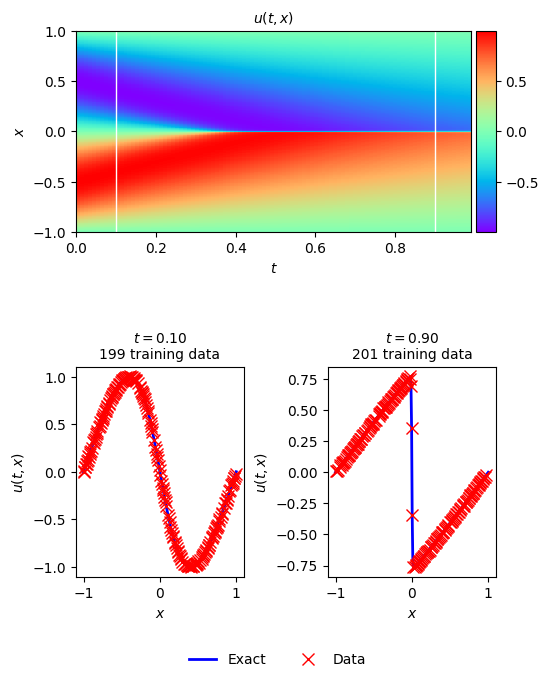

In [ ]:
fig, ax = plt.subplots(figsize=(6, 9))
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3+0.05, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact, interpolation='nearest', cmap='rainbow',
              extent=[t_star.min(), t_star.max(), x_star.min(), x_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x_star.min(), x_star.max(), 2)[:, None]
ax.plot(t_star[idx_t]*np.ones((2, 1)), line, 'w-', linewidth=1.0)
ax.plot(t_star[idx_t + skip]*np.ones((2, 1)), line, 'w-', linewidth=1.0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(t,x)$', fontsize=10)

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-1/3-0.1, bottom=1-2/3, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_star, Exact[:, idx_t], 'b-', linewidth=2, label='Exact')
ax.plot(x0, u0.detach().numpy(), 'rx', markersize=8, label='Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title(f'$t = {t_star[idx_t][0]:.2f}$\n{u0.shape[0]} training data', fontsize=10)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_star, Exact[:, idx_t + skip], 'b-', linewidth=2, label='Exact')
ax.plot(x1, u1.detach().numpy(), 'rx', markersize=8, label='Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title(f'$t = {t_star[idx_t + skip][0]:.2f}$\n{u1.shape[0]} training data', fontsize=10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.3), ncol=2, frameon=False)

gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1-2/3-0.05, bottom=0, left=0.15, right=0.85, wspace=0.0)

#TODO: draw the table

plt.show()
